In [12]:
import pandas as pd
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.fft import fft, fftfreq
from Bio import Entrez, SeqIO, AlignIO, pairwise2, Align, Seq, motifs
from Bio.Seq import Seq
from Bio.SeqFeature import SeqFeature, FeatureLocation
from scipy.stats import binom
import math
import random
from tqdm import tqdm
from Comparative_Analysis import Sequence_Analysis_Routines as sar
from Comparative_Analysis import HMM as hmm
from Comparative_Analysis import Utilities as util
from Comparative_Analysis import Alignment_HMM as alignment_hmm
from Comparative_Analysis import Alignment_Analysis as alignment_analysis
from Comparative_Analysis import Alignment as align
from Comparative_Analysis import Master_Alignment_HMM as master_alignment_hmm
from Comparative_Analysis import Multi_Species_Master_Alignment_HMM as multi_species_master_alignment_hmm
from Comparative_Analysis import Arneson_Ernst_HMM as ae_hmm
import random
from joblib import Parallel, delayed

In [20]:
project_dir = 'D:/Project_Data/Project_6'
genome_datasets_dir = project_dir + '/Datasets/NCBI_Datasets'
literature_datasets_dir = project_dir + '/Datasets/Data_From_Publications'
cryptic_output_path = "D:/Project_Data/CRYPTIC_DATA/Cryptic_Data_Analysis"
cryptic_input_path = "D:/Project_Data/CRYPTIC_DATA/"
output_dir = project_dir + '/Output'
protein_fasta_output_loc = output_dir + '/Protein_Sequences'
outgroup_protein_fasta_output_loc = output_dir + '/Protein_Sequences_With_Outgroup'
sonic_paranoid_run_name = 'Run_Without_Outgroup'
outgroup_sonic_paranoid_run_name = 'Run_With_Outgroup'
sonic_paranoid_output_loc = output_dir + '/Sonic_Paranoid_Output'
ortholog_dir = sonic_paranoid_output_loc + '/runs/' + sonic_paranoid_run_name + '/ortholog_groups'
outgroup_ortholog_dir = sonic_paranoid_output_loc + '/runs/' + outgroup_sonic_paranoid_run_name + '/ortholog_groups'
non_cds_output_dir = output_dir + '/Multiple_Alignment_Data/Downstream_Non_CDS'
upstream_non_cds_output_dir = output_dir + '/Multiple_Alignment_Data/Upstream_Non_CDS'
cds_output_dir = output_dir + '/Multiple_Alignment_Data/CDS'
extended_cds_output_dir = output_dir + '/Multiple_Alignment_Data/Extended_CDS'
extended_non_cds_regions_output_dir = output_dir + '/Multiple_Alignment_Data/Extended_Non_CDS'
outgroup_cds_output_dir = output_dir + '/Multiple_Alignment_Data/CDS_With_Outgroup'
outgroup_concatenated_cds_output_dir = output_dir + '/Multiple_Alignment_Data/CDS_With_Outgroup_Concatenated'
hmm_parameters_output_dir = output_dir +'/HMM_Model_Parameters'
conservation_analysis_output_dir = output_dir + '/Conservation_Analysis'
num_cores = 16

In [14]:
with open(cryptic_output_path + '/' + 'variant_count_dictionary.pkl', 'rb') as f:
    variant_count_dict = pickle.load(f)  
with open(cryptic_output_path + '/' + 'variant_count_by_lineage_dictionary.pkl', 'rb') as f:
    variant_count_by_lineage_dict = pickle.load(f)

In [107]:
genome_record = next(SeqIO.parse(genome_datasets_dir + '/GCF_000195955.2/genomic.gbff', "genbank"))
full_sequence = genome_record.seq
actual_cds_boundaries = []
#for feature in genome_record.features:
#        if feature.type == 'CDS':
#            a = feature.qualifiers  
#            actual_cds_boundaries.append((a.get("locus_tag")[0], int(feature.location.start), int(feature.location.end), int(feature.location.strand)))   

temp = pd.read_excel(literature_datasets_dir+'/Mycobrowser_Release_4.xlsx')
temp = temp[temp['Feature'] == 'CDS'][['Locus','Start','Stop','Strand']]
actual_cds_boundaries = []
for i, r in temp.iterrows():
    if r['Strand'] == '+':
        strand = 1
    else:
        strand = -1
    actual_cds_boundaries.append((r['Locus'],r['Start']-1, r['Stop'], strand))

In [16]:
print(min([x[2]-x[1] for x in actual_cds_boundaries]))

90


In [17]:
def bin_formula(max_bin_counts, tot_bin_counts, in_frame = False):
    #successes = 0
    #if in_frame == False:
    #    for i in range(10000):
    #        a = np.random.default_rng().multinomial(tot_bin_counts, np.array([1/3, 1/3, 1/3]), size=None)
    #        if max(a) >= max_bin_counts:
    #            successes +=1
    #else:
    #    for i in range(10000):
    #        a = np.random.default_rng().multinomial(tot_bin_counts, np.array([1/3, 1/3, 1/3]), size=None)
    #        if a[0] >= max_bin_counts:
    #            successes +=1
    #return successes / 10000
    return 1- binom.cdf(max_bin_counts-1, tot_bin_counts,1/3)

In [18]:
def mutation_bin_probability(start, end, strand):
    mutations = []
    for i in range(start,end):
        for letter in ['a','c','g','t']:
            if (i+1, 'SNP', letter) in variant_count_dict:        #Variant count dictionary positions are one indexed
                mutations.append(i)
    bin_counts =[0,0,0]
    for m in mutations:
        if strand == 1:
            bin_counts[(m-(start))%3] +=1
        else:
            bin_counts[((end-1)-m)%3] +=1
    if sum(bin_counts) == 0:
        return (1, sum(bin_counts), bin_counts)
    else:
        return (bin_formula(bin_counts[2], sum(bin_counts)), sum(bin_counts), bin_counts)  

In [22]:
temp1 = pd.read_csv(cryptic_input_path + 'MYKROBE_LINEAGE.csv')
temp2 = list(temp1['MYKROBE_LINEAGE_NAME_2'].unique())
lineage_names = [x for x in temp2 if not('/' in x) and not (x=='Unknown') and not('clade' in x) and not('Bovis' in x) and not('Caprae' in x)]

In [23]:
def mutation_bin_probability_2(start, end, strand):
    mutations = []
    for i in range(start,end):
        for lineage in lineage_names:
            num_different_letters = 0
            for letter in ['a','c','g','t']:
                if (i+1, 'SNP', letter) in variant_count_dict:        #Variant count dictionary positions are one indexed
                    num_different_letters += 1
            if num_different_letters > 1:
                for j in range(num_different_letters - 1):
                    mutations.append(i)
    bin_counts =[0,0,0]
    for m in mutations:
        if strand == 1:
            bin_counts[(m-(start))%3] +=1
        else:
            bin_counts[((end-1)-m)%3] +=1
    if sum(bin_counts) == 0:
        return (1, sum(bin_counts), bin_counts)
    else:
        return (bin_formula(bin_counts[2], sum(bin_counts)), sum(bin_counts), bin_counts)  

In [56]:
def max_orf(seq_start, seq_stop):
    max_len = 0
    orf_length = 0
    start_pos = -999
    end_pos = -999
    for frame in ['Forward', 'Reverse']:
        if frame == 'Forward':
            temp = (full_sequence[seq_start: seq_stop])
        else:
            temp = align.reverse_complement(full_sequence[seq_start: seq_stop])
        seq_len = len(temp)
        for i in range(seq_len - 2):
            test_codon = temp[i: i+3] 
            if test_codon in ['ATG','GTG','TTG']:  #Missed out CTG as doesn't seem to be used very much at all
                for j in range(i + 3, seq_len - 2, 3):
                    test_codon_2 = temp[j: j+3] 
                    if test_codon_2 in ['TAG','TGA','TAA']:
                        orf_length = j - i
                        break
                if orf_length > max_len and ((frame == 'Forward' and mutation_bin_probability_2(seq_start+i, seq_start+j+3, 1)[0]<0.001)
                                             or (frame == 'Reverse' and mutation_bin_probability_2(seq_start+seq_len-(j+3), seq_start+seq_len-i, -1)[0]<0.001)):
                    max_len = orf_length
                    if frame == 'Forward':
                        strand = 1
                        start_pos = i
                        end_pos = j+3
                        
                    else:
                        strand = -1
                        start_pos = seq_len-(j+3)
                        end_pos = seq_len-i
                       
      
    if start_pos == -999:
        return(0,0,0)
    else:
        return(seq_start+start_pos, seq_start+end_pos, strand)   #, mutation_bin_probability(seq_start+start_pos, seq_start+end_pos, strand, in_frame=True))

In [57]:
max_orf(0,15000)

(7301, 9818, 1)

In [58]:
mutation_bin_probability(748598,749504,-1)

(0.0, 544, [132, 132, 280])

In [59]:
mutation_bin_probability_2(748598,749504,-1)

(0.0, 8125, [1300, 910, 5915])

In [60]:
num_iterations = 0
cds_boundaries = [[0, 0], [4411530, 4411530]]
cds_dict = {}
for i in cds_boundaries:
    cds_dict[tuple(i)] = 1
exhausted_cds = []
while len(exhausted_cds) < len(cds_boundaries) - 1:
    temp_boundaries = []
    for i, (x,y) in enumerate((cds_boundaries)):
        if i < len(cds_boundaries) - 1:
            if [x,y] in exhausted_cds:
                pass
            else:
                temp = cds_boundaries[i+1][0]
                res = max_orf(y, temp)
                if (res[1] - res[0] < 100):
                    exhausted_cds.append([x,y])
                else:
                    temp_boundaries.append([res[0], res[1]])
                    cds_dict[(res[0],res[1])] = res[2]
                
    cds_boundaries = sorted(cds_boundaries + temp_boundaries, key=lambda x: x[0])
    print("iteration " + str(num_iterations) + ":  "+str(len(cds_boundaries))+ " found.  "+str(len(exhausted_cds))+" exhausted regions")
    num_iterations += 1

iteration 0:  3 found.  0 exhausted regions
iteration 1:  5 found.  0 exhausted regions
iteration 2:  9 found.  0 exhausted regions
iteration 3:  17 found.  0 exhausted regions
iteration 4:  32 found.  1 exhausted regions
iteration 5:  60 found.  3 exhausted regions
iteration 6:  110 found.  9 exhausted regions
iteration 7:  195 found.  24 exhausted regions
iteration 8:  341 found.  48 exhausted regions
iteration 9:  548 found.  133 exhausted regions
iteration 10:  831 found.  264 exhausted regions
iteration 11:  1165 found.  496 exhausted regions
iteration 12:  1576 found.  753 exhausted regions
iteration 13:  2011 found.  1140 exhausted regions
iteration 14:  2453 found.  1568 exhausted regions
iteration 15:  2889 found.  2016 exhausted regions
iteration 16:  3325 found.  2452 exhausted regions
iteration 17:  3738 found.  2911 exhausted regions
iteration 18:  4100 found.  3375 exhausted regions
iteration 19:  4403 found.  3796 exhausted regions
iteration 20:  4635 found.  4170 exhaus

In [61]:
t_lengths = [x[1]-x[0] for x in cds_boundaries]
a_lengths = [x[2]-x[1] for x in actual_cds_boundaries]

<AxesSubplot:ylabel='Count'>

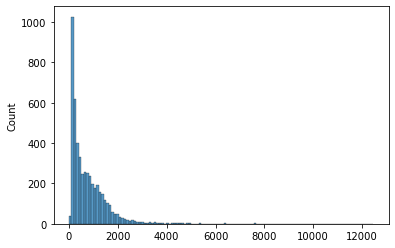

In [62]:
sns.histplot(t_lengths)

<AxesSubplot:ylabel='Count'>

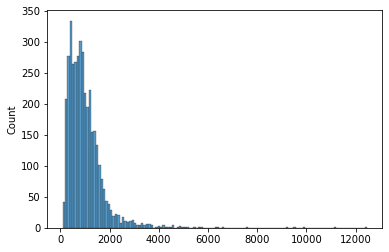

In [42]:
sns.histplot(a_lengths)

In [63]:
def max_overlap(boundary, comparison_boundaries):
    max_overlap = 0
    comparison_boundary_0 = 0
    comparison_boundary_1 = 0
    locus = ''
    strand = 1
    for bound in comparison_boundaries:
        overlap = min(boundary[1], bound[2]) - max(boundary[0], bound[1])
        if overlap > max_overlap:
            max_overlap = overlap
            comparison_boundary_0 = bound[1]
            comparison_boundary_1 = bound[2]
            locus = bound[0]
            strand = bound[3]
    return(locus, strand, comparison_boundary_0, comparison_boundary_1, max_overlap)

In [64]:
temp = []
for bound in tqdm(cds_boundaries):
    a = max_overlap(bound, actual_cds_boundaries)
    if a[3] > 0:
        temp.append([a[0],a[1],a[2],a[3],a[4], cds_dict[(bound[0],bound[1])], bound[0], bound[1], bound[0]-a[2], bound[1]-a[3]])
df = pd.DataFrame(temp, columns = ['locus','annotation_strand','annotation_start','annotation_end', 'overlap', 'simulated_strand','simulated_start', 'simulated_end', 'start_offset','end_offset'])

100%|██████████| 5007/5007 [00:04<00:00, 1224.36it/s]


In [65]:
matched_genes = df.query('start_offset == 0 and end_offset == 0')
print(len(matched_genes))

1371


In [53]:
print(align.reverse_complement(full_sequence[1173900:1174869]))

GTGCGGGACCGGCGCACCGACGCAGGAGTACCTGACTCGACACACCCTCGAATCGTTCCTGGATCGGCTCACCCGCACCTCGCATGCCGCAGACTTCGTCCTCAAAGGCCGGATCCTGCTGGCCGCCTACGGCGTTCGGCACCCGACGAAGGACACCGACTCCAACGCCATGCGCGCCGACGTCACCGCCGAGCATCTCACCCAGGTGGTTCGCGACATCGCCGTGATCGACATCGACGACGGGGTGGCGTTCAACCTCGACACGAGCAGCGTGCAGGAAATTCGCGAGCGGGCCGACTACCCGGGCCTGCGCGTGCGAGTCGCTATGTCGGTCGGACCGTGGCAGGGCATCGCGGCCTGGGATGTGTCCACCGGCGAACCGATCGCGCCGTGGCCCACACGGGTGACCATCGACCGGATCCTCGGCGAGCCGATCACACTCCTGGGCTACGCGCCCGAGACCATCATCGCCGAGAAGGGAGTGACCATCCTCGAACGCGGCATCACCAGCACCCGCTGGCGGGACTACGTCGACATCGTCCAACTCGACCGCCGGGGCATCGACGACGACGAGCTGCTCCGCTCGGCCAGGGCAGTCGCACAATACCGCGGCGCCACTCTCGAACCCGTCGCGCCTCACCTGGCCGGTTATGGCGCAGTCGCGCAAGCGAAATGGGCGACCGAACACGGACGCTGCCAGCACTGTTGGAGACATTGGAAACCAGCCCATGTCGGGAGGAGAAACATGGATCTGCTGGACGCAAAACAAGTTTCGGAGATGATCGGCGTTCCCGTCGGCACTCTACGGCACTGGCGGCACTCGGACATCGGACCGGCGAGCTTCACCTTGGGACGGCGCGTCGTGTACCGGCGCGACGAGGTGTCGCGCTGGATCTCAAAGCGGGAGAGCGCAACTCGACGTTGAGCTGGCGCCCGACGACGAACTGCGTGATCGGCTTGCCCGGGTGA


In [49]:
codon_dict = {}
with open('D:/Project_Data/Project_3/Datasets/Reference_Tables/Standard_Code.txt') as f:
    for l in f:
        codon_dict[str(l[1:4])] = l[5]

In [50]:
def translate_sequence(input_seq):
    output_seq = ''
    seq = input_seq
    for i in range(0,len(seq)-2,3):
        if seq[i:(i+3)] in codon_dict:
            output_seq += codon_dict[seq[i:(i+3)]]
        else:
            output_seq += 'X'
    return output_seq

In [80]:
print(translate_sequence(align.reverse_complement(full_sequence[932150: 932915])))

VPRSTALALLPRGAAAGHQRHRYRRDPEQLGPLRGNSGHLPRPGQHRAPIPDRRPRRRCPPVRRGGVAHRHNPPSPRQPAHERPRMHRRLPACRCSASPWRPDSPPSPTAELCGPQTARMARSVRGPRLQRRPRSGLGGALVRRRPRPALRQTRPVGATPSRLRPTHRRCRAARPRHARQCQRTGGRRAGDARHTGRPRPAGPALRRGSTGLAHHHSFAAPAGRGVTRPAHAGLLNANRNHKCTFSNGASYRIG*


In [112]:
print(translate_sequence((full_sequence[2614179: 2614656])))

VSRWALINRRKPGFASIAESHRVAWRLLTLENKMYSLRQNKRRGNFARSSIPPRLTHILAAFPQPSPGITDQTLGLPTSGHGAKVDSQNMAVRDMGIHGTEPLRRPVRFNLHMSGAAAVVRYVEHRWRSGAGRLVFSCDASAPPRQPPRAKQVLMPQC*


In [84]:
print(df)

        locus  annotation_strand  annotation_start  annotation_end  overlap  \
0      Rv0001                  1                 0            1524     1524   
1      Rv0002                  1              2051            3260     1209   
2      Rv0003                  1              3279            4437     1158   
3      Rv0004                  1              4433            4997      516   
4      Rv0005                  1              5239            7267     2028   
...       ...                ...               ...             ...      ...   
4483  Rv3919c                 -1           4407527         4408202      409   
4484  Rv3920c                 -1           4408333         4408897      156   
4485  Rv3921c                 -1           4408968         4410069     1101   
4486  Rv3923c                 -1           4410411         4410789      378   
4487  Rv3924c                 -1           4410785         4410929       57   

      simulated_strand  simulated_start  simulated_

In [86]:
out_list = []
for i in actual_cds_boundaries:
    
    if mutation_bin_probability_2(i[1],i[2],i[3])[0] > 0.3:
        
        temp = df[df['locus'] == i[0]]
        if len(temp)== 1:
            alt_len = temp.iloc[0]['simulated_end'] - temp.iloc[0]['simulated_start']
            if mutation_bin_probability_2(temp.iloc[0]['simulated_start'],temp.iloc[0]['simulated_end'],temp.iloc[0]['simulated_strand'])[0]<0.1 and alt_len > 700 :
                print(temp.iloc[0]['locus'])
                print ([i[1],i[2],i[3]],mutation_bin_probability_2(i[1],i[2],i[3]))
                print ("alternative", str(alt_len))
                print([temp.iloc[0]['simulated_start'],temp.iloc[0]['simulated_end'],temp.iloc[0]['simulated_strand']], mutation_bin_probability_2(temp.iloc[0]['simulated_start'],temp.iloc[0]['simulated_end'],temp.iloc[0]['simulated_strand']))
                out_list.append([temp.iloc[0]['locus'], temp.iloc[0]['annotation_start'], temp.iloc[0]['annotation_end'], temp.iloc[0]['annotation_strand'], temp.iloc[0]['simulated_start'],temp.iloc[0]['simulated_end'],temp.iloc[0]['simulated_strand']])
                if temp.iloc[0]['simulated_strand'] == 1:
                    print(translate_sequence((full_sequence[temp.iloc[0]['simulated_start']: temp.iloc[0]['simulated_end']])))
                else:
                    print(translate_sequence(align.reverse_complement(full_sequence[temp.iloc[0]['simulated_start']: temp.iloc[0]['simulated_end']])))
tempdf = pd.DataFrame(out_list, columns = ['locus','annotation_start','annotation_end', 'annotation_strand', 'simulated_start', 'simulated_end', 'simulated_strand'])      
tempdf.to_csv(cryptic_output_path + '/nick.csv')

Rv0600c
[697903, 698410, -1] (0.9999999999998995, 2015, [780, 715, 520])
alternative 843
[697975, 698818, 1] (6.308911067898215e-06, 3900, [1105, 1365, 1430])
VEGRPRCGEGDAEFGPAVGVVGGVGMSAVGGGEGGDDGQAEAAAATAAGGVGAGESVEGDGKKVVGESGAVVADADVDCTVAGVRGDSDFTVPVGDGVVEHGGEDSAQVVRIDRDEQVRFRACGDVRSSSGEAGHALVQQGSDRHRFGGGVGFGAVGAGQGEQLVGQSAEPAGFFERGAQGGAQLVGGSGPAQRSSSSVVSSANGVRNSWLASATNCCSWARARCSRVSMVLRVVASQAISSSVGGTGSGASVSGCGVVVSVCAAARIRSTGRSAARLSR*
Rv0643c
[737267, 738149, -1] (0.5269100113476428, 195, [65, 65, 65])
alternative 906
[737267, 738173, -1] (0.0, 455, [65, 130, 260])
VPLTVGGHMSDNSTGTTKSRSNVDDVQAHYDLSDAFFALFQDPTRTYSCAYFERDDMTLHEAQVAKLDLTLGKLGLEPGMTLLDVGCGWGSVMKRAVERYDVNVVGLTLSKNQHAYCQQVLDKVDTNRSHRVLLSDWANFSEPVDRIVTIEAIEHFGFERYDDFFKFAYNAMPADGVMLLHSITGLHVKQVIERGIPLTMEMAKFIRFIVTDIFPGGRLPTIETIEEHVTKAGFTITDIQSLQPHFARTLDLWAEALQAHKDEAIEIQSAEVYERYMKYLTGCAKAFRMGYIDCNQFTLAK*
Rv0833
[925360, 927610, 1] (0.9999999639602964, 325, [130, 130, 65])
alternative 2439
[925207, 927646, -1] (1.4440288293449

In [108]:
print(actual_cds_boundaries[1][0])

Rv0002


In [111]:
out_list = []
for i, (loc_name, x,y, strand) in enumerate((actual_cds_boundaries)):
    if i < len(actual_cds_boundaries) - 1:
        temp = actual_cds_boundaries[i+1][1]
        if temp - y > 400:
            res = max_orf(y, temp)
            mut_prob = mutation_bin_probability_2(res[0],res[1],res[2])[0]
            if mut_prob < 0.01 and res[0] > 0 and res[1] - res[0] > 400:
                print(loc_name, res, mut_prob)
                out_list.append([loc_name, res[0], res[1], res[2], mut_prob])
df=pd.DataFrame(out_list,columns=['locus','start','end','strand','p_value'])

Rv0192A (223998, 224664, 1) 0.0
Rv2338c (2614179, 2614656, 1) 2.19824158875781e-12
Rv2511 (2827850, 2828252, 1) 1.5087930904655877e-13
Rv3333c (3720824, 3721238, 1) 2.220446049250313e-16
Rv3428c (3846006, 3846432, 1) 3.840357165918462e-05


In [97]:
temp = pd.read_excel(literature_datasets_dir+'/Mycobrowser_Release_4.xlsx')
temp = temp[temp['Feature'] == 'CDS'][['Locus','Start','Stop','Strand']]

In [104]:
temp = pd.read_excel(literature_datasets_dir+'/Mycobrowser_Release_4.xlsx')
temp = temp[temp['Feature'] == 'CDS'][['Locus','Start','Stop','Strand']]
actual_cds_boundaries_2 = []
for i, r in temp.iterrows():
    if r['Strand'] == '+':
        strand = 1
    else:
        strand = -1
    actual_cds_boundaries_2.append((r['Locus'],r['Start']-1, r['Stop'], strand))

In [105]:
actual_cds_boundaries[0:5]

[('Rv0001', 0, 1524, 1),
 ('Rv0002', 2051, 3260, 1),
 ('Rv0003', 3279, 4437, 1),
 ('Rv0004', 4433, 4997, 1),
 ('Rv0005', 5239, 7267, 1)]

In [106]:
actual_cds_boundaries_2[0:5]

[('Rv0001', 0, 1524, 1),
 ('Rv0002', 2051, 3260, 1),
 ('Rv0003', 3279, 4437, 1),
 ('Rv0004', 4433, 4997, 1),
 ('Rv0005', 5239, 7267, 1)]